## Another example, now with a conditional edge

In [1]:
from dotenv import load_dotenv

In [2]:
from typing import Annotated, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from pydantic import BaseModel, Field
from typing_extensions import TypedDict

In [3]:
load_dotenv()

llm = init_chat_model(
    model="openai:gpt-4o"
)

In [4]:
class MessageClassifier(BaseModel):
    message_type: Literal["emotional", "logical"] = Field(
        ...,
        description="Classify if the message requires an emotional (therapist) or logical response."
    )


In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    message_type: str | None

In [6]:
def classify_message(state: State):
    print('called classify agent and the state has this number of messages:', len(state["messages"]))

    last_message = state["messages"][-1]
    classifier_llm = llm.with_structured_output(MessageClassifier)

    result = classifier_llm.invoke([
        {
            "role": "system",
            "content": """Classify the user message as either:
            - 'emotional': if it asks for emotional support, therapy, deals with feelings, or personal problems
            - 'logical': if it asks for facts, information, logical analysis, or practical solutions
            """
        },
        {"role": "user", "content": last_message.content}
    ])
    return {"message_type": result.message_type}

In [7]:
def router(state: State):
    message_type = state.get("message_type", "logical")
    if message_type == "emotional":
        return {"next": "therapist"}

    return {"next": "logical"}

In [8]:
def therapist_agent(state: State):

    print('called therapist agent and the state has this number of messages:', len(state["messages"]))

    last_message = state["messages"][-1]

    messages = [
        {"role": "system",
         "content": """You are a compassionate therapist. Focus on the emotional aspects of the user's message.
                        Show empathy, validate their feelings, and help them process their emotions.
                        Ask thoughtful questions to help them explore their feelings more deeply.
                        Avoid giving logical solutions unless explicitly asked."""
         },
        {
            "role": "user",
            "content": last_message.content
        }
    ]
    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}

In [9]:
def logical_agent(state: State):

    print('called logical agent and the state has this number of messages:', len(state["messages"]))

    last_message = state["messages"][-1]

    messages = [
        {"role": "system",
         "content": """You are a purely logical assistant. Focus only on facts and information.
            Provide clear, concise answers based on logic and evidence.
            Do not address emotions or provide emotional support.
            Be direct and straightforward in your responses."""
         },
        {
            "role": "user",
            "content": last_message.content
        }
    ]
    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}

In [10]:
graph_builder = StateGraph(State)

graph_builder.add_node("classifier", classify_message)
graph_builder.add_node("router", router)
graph_builder.add_node("therapist", therapist_agent)
graph_builder.add_node("logical", logical_agent)

In [11]:
graph_builder.add_edge(START, "classifier")
graph_builder.add_edge("classifier", "router")

In [12]:
graph_builder.add_conditional_edges(
    "router",
    lambda state: state.get("next"),
    {"therapist": "therapist", "logical": "logical"}
)

graph_builder.add_edge("therapist", END)
graph_builder.add_edge("logical", END)


In [13]:
graph = graph_builder.compile()

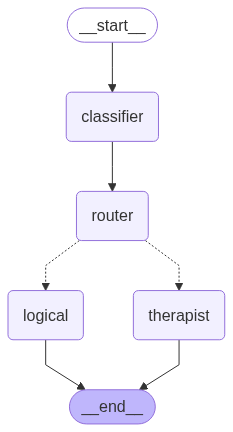

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Error displaying graph:", e)
    

In [15]:
def run_chatbot():
    state = {"messages": [], "message_type": None}

    while True:
        user_input = input("Message: ")
        if user_input == "exit":
            print("Bye")
            break

        state["messages"] = state.get("messages", []) + [
            {"role": "user", "content": user_input}
        ]

        state = graph.invoke(state)

        if state.get("messages") and len(state["messages"]) > 0:
            last_message = state["messages"][-1]
            print(f"Assistant: {last_message.content}")

In [16]:
run_chatbot()

called classify agent and the state has this number of messages: 1
called therapist agent and the state has this number of messages: 1
Assistant: I'm really sorry to hear that you're feeling sad. It's important to acknowledge those emotions, and I'm here to listen. Would you like to share more about what's on your mind or what might be contributing to these feelings?
called classify agent and the state has this number of messages: 3
called therapist agent and the state has this number of messages: 3
Assistant: It sounds like you're really struggling with something right now. Deciding to quit can be such an emotionally charged decision and often comes with a whole mix of feelings. Can you share a bit more about what's going on for you? How are you feeling about possibly making this change?
Bye


In [17]:
# credits TechWithTim Channel